# Gaussian Process Regression with Newly Proposed API

In [1]:
from matplotlib import pyplot as plt

import math
import torch

# Numerics and scientific computing
torch.set_default_dtype(torch.float32)
torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

## Data

In [2]:
train_x = torch.linspace(0, 1, 50)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

## Model

In [3]:
from gpytorch import models, means, kernels

model = models.GaussianProcess(
    mean=means.ZeroMean(),
    kernel=kernels.ScaleKernel(kernels.MaternKernel()),
    train_inputs=train_x,
    train_targets=train_y,
)
model

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


GaussianProcess(
  (mean): ZeroMean()
  (kernel): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (approximation_strategy): Cholesky()
)

In [5]:
list(model.named_parameters())

[('kernel.raw_outputscale',
  Parameter containing:
  tensor(0., requires_grad=True)),
 ('kernel.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0.]], requires_grad=True)),
 ('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([0.], requires_grad=True))]

## Training

In [6]:
from gpytorch import mlls

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = mlls.ExactMarginalLogLikelihood(model.likelihood, model)

training_iter = 100
for i in range(training_iter):
    optimizer.zero_grad()

    f_pred = model(train_x)
    loss = -mll(f_pred, train_y)
    loss.backward()

    print(
        "Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f"
        % (
            i + 1,
            training_iter,
            loss.item(),
            model.kernel.base_kernel.lengthscale.item(),
            model.likelihood.noise.item(),
        )
    )
    optimizer.step()

Iter 1/100 - Loss: 0.954   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.920   lengthscale: 0.644   noise: 0.644
Iter 3/100 - Loss: 0.884   lengthscale: 0.598   noise: 0.598
Iter 4/100 - Loss: 0.846   lengthscale: 0.554   noise: 0.554
Iter 5/100 - Loss: 0.807   lengthscale: 0.513   noise: 0.513
Iter 6/100 - Loss: 0.767   lengthscale: 0.473   noise: 0.474
Iter 7/100 - Loss: 0.727   lengthscale: 0.437   noise: 0.437
Iter 8/100 - Loss: 0.689   lengthscale: 0.403   noise: 0.402
Iter 9/100 - Loss: 0.653   lengthscale: 0.372   noise: 0.370
Iter 10/100 - Loss: 0.619   lengthscale: 0.345   noise: 0.339
Iter 11/100 - Loss: 0.586   lengthscale: 0.323   noise: 0.311
Iter 12/100 - Loss: 0.554   lengthscale: 0.306   noise: 0.285
Iter 13/100 - Loss: 0.522   lengthscale: 0.293   noise: 0.260
Iter 14/100 - Loss: 0.489   lengthscale: 0.285   noise: 0.238
Iter 15/100 - Loss: 0.455   lengthscale: 0.280   noise: 0.217
Iter 16/100 - Loss: 0.422   lengthscale: 0.280   noise: 0.198
Iter 17/100 - Los

## Prediction

In [7]:
model.eval()

with torch.no_grad():
    test_x = torch.linspace(-0.2, 1.2, 100)
    f_pred = model(test_x)
    y_pred = model.likelihood(f_pred)

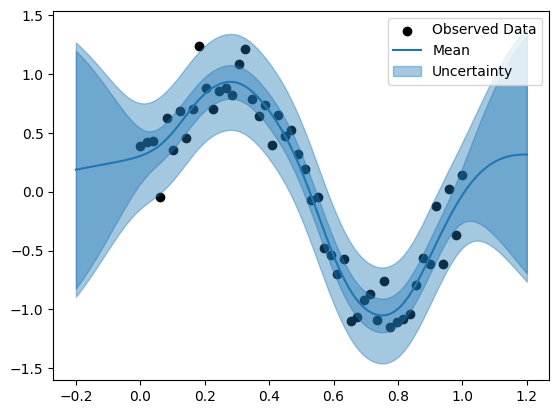

In [8]:
with torch.no_grad():
    fig, ax = plt.subplots(1, 1)

    f_pred_lower, f_pred_upper = f_pred.confidence_region()
    y_pred_lower, y_pred_upper = y_pred.confidence_region()
    ax.scatter(train_x.numpy(), train_y.numpy(), color="black")
    ax.plot(test_x.numpy(), y_pred.mean.numpy(), color="C0")
    ax.fill_between(test_x.numpy(), y_pred_lower, y_pred_upper, alpha=0.4, color="C0")
    ax.fill_between(test_x.numpy(), f_pred_lower, f_pred_upper, alpha=0.4, color="C0")
    ax.legend(["Observed Data", "Mean", "Uncertainty"])